<a href="https://colab.research.google.com/github/parvezmosaraf/Machine-Learning-Project/blob/main/DenseNet121_Plant_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import pandas as pd
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, load_model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [69]:
#for dirname, _, filenames in os.walk('/content/sample_data'):
    #for filename in filenames:
       #print(os.path.join(dirname, filename))

In [70]:
disease_types =['Apple___Apple_scab','Apple___Black_rot','Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Early_blight','Tomato_Late_blight','Tomato__Target_Spot','Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = '/content/drive/MyDrive/plant village dataset-custom'
train_dir = os.path.join(data_dir)

In [71]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
1525,Tomato_healthy/fdbbea63-18e0-401f-8269-64ba005...,11,Tomato_healthy
1526,Tomato_healthy/f4d64977-50b0-4967-87cf-95f282f...,11,Tomato_healthy
1527,Tomato_healthy/fd75c626-bda9-4388-8b29-75d40ea...,11,Tomato_healthy
1528,Tomato_healthy/f163df8f-6510-4520-82ee-779d267...,11,Tomato_healthy
1529,Tomato_healthy/fae1be6a-cac5-481b-96ab-4a4abae...,11,Tomato_healthy


In [72]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Potato___Late_blight/05a51957-779c-4a2f-bf2a-d...,5,Potato___Late_blight
1,Apple___Apple_scab/45000608-507a-46f5-be52-3ee...,0,Apple___Apple_scab
2,Apple___Black_rot/4e6311ab-8927-4147-9857-a669...,1,Apple___Black_rot
3,Tomato__Tomato_mosaic_virus/5d5ee5fc-35e3-4be9...,10,Tomato__Tomato_mosaic_virus
4,Pepper__bell___healthy/47aec3a3-7a19-4829-9cd1...,3,Pepper__bell___healthy


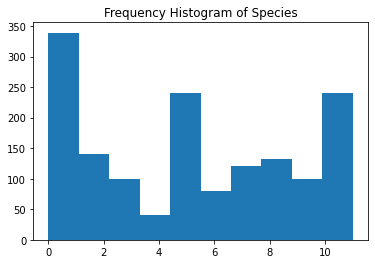

<Figure size 864x864 with 0 Axes>

In [73]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

In [74]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [75]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

1530it [00:05, 278.60it/s]


Train Shape: (1530, 64, 64, 3)


In [76]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=12)

In [77]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

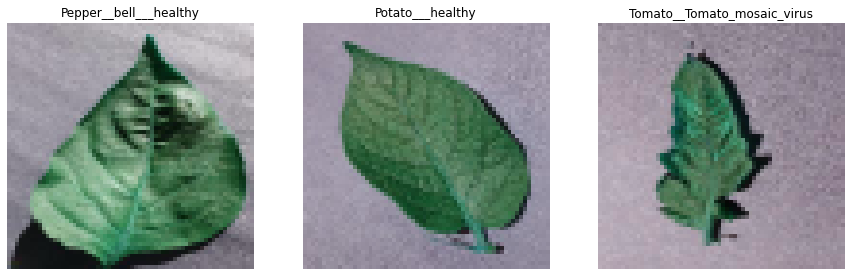

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [79]:
EPOCHS = 100
SIZE=64
N_ch=3

In [80]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(12,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [81]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_5   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_10 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0   

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100

Epoch 1: val_loss improved from inf to 2.70353, saving model to model.h5
19/19 - 77s - loss: 3.8497 - accuracy: 0.0828 - val_loss: 2.7035 - val_accuracy: 0.0817 - lr: 0.0020 - 77s/epoch - 4s/step
Epoch 2/100

Epoch 2: val_loss improved from 2.70353 to 2.55000, saving model to model.h5
19/19 - 5s - loss: 3.7213 - accuracy: 0.0979 - val_loss: 2.5500 - val_accuracy: 0.1209 - lr: 0.0020 - 5s/epoch - 282ms/step
Epoch 3/100

Epoch 3: val_loss improved from 2.55000 to 2.41244, saving model to model.h5
19/19 - 4s - loss: 3.4227 - accuracy: 0.1371 - val_loss: 2.4124 - val_accuracy: 0.1961 - lr: 0.0020 - 4s/epoch - 215ms/step
Epoch 4/100

Epoch 4: val_loss improved from 2.41244 to 2.34759, saving model to model.h5
19/19 - 3s - loss: 3.0097 - accuracy: 0.1836 - val_loss: 2.3476 - val_accuracy: 0.1895 - lr: 0.0020 - 3s/epoch - 182ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 2.34759
19/19 - 2s - loss: 2.8699 - accuracy: 0.1974 - val_loss: 2.4000 - val_accuracy: 0.2680 - 

In [82]:
model = load_model('/content/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

10/10 [==============================] - 2s 26ms/step - loss: 0.2336 - accuracy: 0.9118
Final Loss: 0.2335909903049469, Final Accuracy: 0.9117646813392639


10/10 [==============================] - 2s 23ms/step


Text(0.5, 144.41374999999996, 'Predicted')

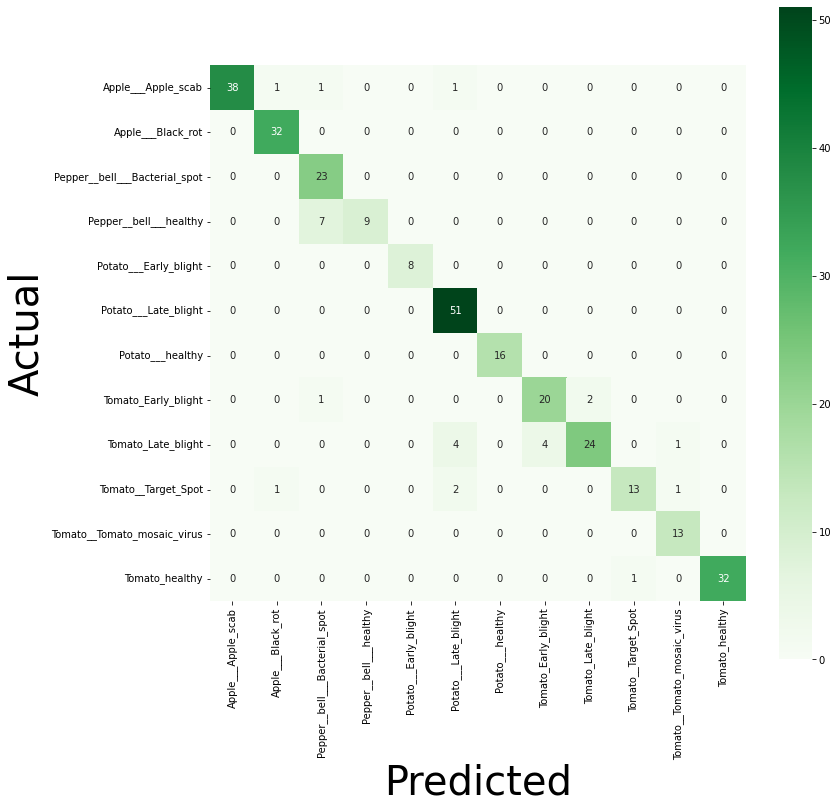

In [83]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

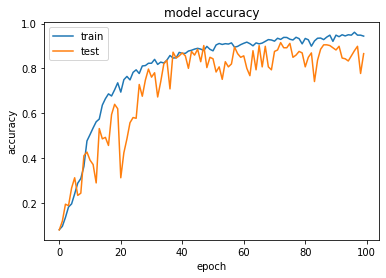

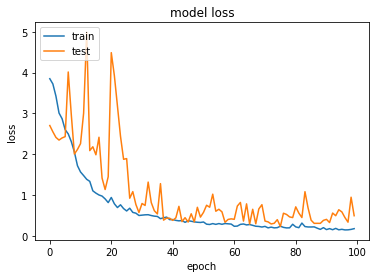

In [84]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 29ms/step
[5.7846886e-05 3.9199437e-03 1.5255901e-03 2.7037578e-04 7.6231402e-03
 1.0015967e-03 9.2213047e-01 5.5843266e-04 2.5527572e-04 1.6918345e-04
 3.2402109e-02 3.0086081e-02]


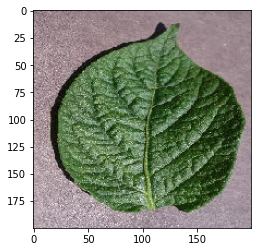

Prediction: Potato___healthy


In [85]:
from skimage import io
import keras.utils as image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/drive/MyDrive/plant village dataset-custom/Tomato_Early_blight/00c5c908-fc25-4710-a109-db143da23112___RS_Erly.B 7778.JPG', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/drive/MyDrive/plant village dataset-custom/Potato___healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG', grayscale=False, target_size=(200, 200))
disease_class = ['Apple___Apple_scab','Apple___Black_rot','Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Early_blight','Tomato_Late_blight','Tomato__Target_Spot','Tomato__Tomato_mosaic_virus','Tomato_healthy']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255

custom = model.predict(x)
print(custom[0])



#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])